### 1. Create FaIR instance

We'll call our instance `f`: it's nice and short and the `fair` name is reserved for the module.

In [100]:
from fair import FAIR

In [101]:
f = FAIR()

### 2. Define time horizon

There are two different time indicators in FaIR: the `timebound` and the `timepoint`. `timebound`s, as the name suggests, are at the edges of each time step; they can be thought of as instantaneous snapshots. `timepoint`s are what happens between time bounds and are rates or integral quantities. 

The main thing to remember is that only `emissions` are defined on `timepoint`s and everything else is defined on `timebound`s, and when we specify the time horizon in our model, we are defining the `timebound`s of the problem.

Secondly, the number of `timebound`s is one more than the number of `timepoint`s, as the start and end points are included in the `timebound`s.

In [102]:
# create time horizon with bounds of 2000 and 2050, at 1-year intervals
f.define_time(2000, 2050, 1)
print(f.timebounds)
print(f.timepoints)

[2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011.
 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021. 2022. 2023.
 2024. 2025. 2026. 2027. 2028. 2029. 2030. 2031. 2032. 2033. 2034. 2035.
 2036. 2037. 2038. 2039. 2040. 2041. 2042. 2043. 2044. 2045. 2046. 2047.
 2048. 2049. 2050.]
[2000.5 2001.5 2002.5 2003.5 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5
 2010.5 2011.5 2012.5 2013.5 2014.5 2015.5 2016.5 2017.5 2018.5 2019.5
 2020.5 2021.5 2022.5 2023.5 2024.5 2025.5 2026.5 2027.5 2028.5 2029.5
 2030.5 2031.5 2032.5 2033.5 2034.5 2035.5 2036.5 2037.5 2038.5 2039.5
 2040.5 2041.5 2042.5 2043.5 2044.5 2045.5 2046.5 2047.5 2048.5 2049.5]


### 3. Define scenarios

The scenarios are a list of strings that label the scenario dimension of the model, helping you keep track of inputs and outputs.

In this example problem we will create two scenarios: an "abrupt" scenario (where emissions or concentrations change instantly) and a "ramp" scenario where they change gradually.

In [103]:
# Define two scenarios
f.define_scenarios(["abrupt", "ramp"])
f.scenarios

['abrupt', 'ramp']

### 4. Define configs

Similarly to the scenarios, the configs are a labelling tool. Each config has associated climate- and species-related settings, which we will come to later. 

We'll use three config sets, crudely corresponding to high, medium and low climate sensitivity.

In [104]:
# Define three scenarios
f.define_configs(["high", "central", "low"])


### 5. Define species

This defines the forcers -- anthropogenic or natural -- that are present in your scenario. A `species` could be something directly emitted like CO2 from fossil fuels, or it could be a category where forcing has to be calculate from precursor emissions like aerosol-cloud interactions.

Each `specie` is assigned a name that is used to distinguish it from other species. You can call the species what you like within the model as long as you are consistent. We also pass a dictionary of `properties` that defines how each specie behaves in the model.

In this example we'll start off running a scenario with CO2 from fossil fuels and industry, CO2 from AFOLU, CH4, N2O, and Sulfur, and Volcanic forcing (note you don't need the full 40 species used in v1.1-1.6, and some additional default ones are included). From these inputs we also want to determine forcing from aerosol-radiation and aerosol-cloud interactions, as well as CO2, CH4 and N2O.

To highlight some of the functionality we'll run CO2 and Sulfur emissions-driven, and CH4 and N2O concentration-driven. (This is akin to an `esm-ssp585` kind of run from CMIP6, though with fewer species). We'll use totally fake data here - this is not intended to represent a real-world scenario but just to highlight how FaIR works. 

Full simulations may have 50 or more species included and the `properties` dictionary can get quite large, so it can be beneficial to edit it in a CSV and load it in. This is what is done here - we have taken the default `species_configs_properties` file and cut it down to keep only the species we care about.

Note the label you have given each specie must appear in the first column of this file.

In [105]:
from fair.io import read_properties

In [106]:
species, properties = read_properties('data/importing-data/species_configs_properties.csv')
f.define_species(species, properties)


In total, we have 9 species in this model. We want to run

1. CO2 fossil and industry
2. CO2 AFOLU
3. Sulfur

with specified emissions. 

We want to run

4. CH4
5. N2O

with specified concentrations. We want to include an external time series from

6. Volcanic

We also want to calculate forcing from CO2, so we need to declare the CO2 as a greenhouse gas in addition to its emitted components:

7. CO2

and we want to calculate forcing from aerosol radiation and aerosol cloud interactions

8. ERFari
9. ERFaci

Let's examine them:

In [107]:
f.species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions']

In [108]:
f.properties

{'CO2 FFI': {'type': 'co2 ffi',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CO2 AFOLU': {'type': 'co2 afolu',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CO2': {'type': 'co2',
  'input_mode': 'calculated',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CH4': {'type': 'ch4',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True},
 'N2O': {'type': 'n2o',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True},
 'Sulfur': {'type': 'sulfur',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chem

`properties` is just a dictionary and `species` just a list. You can define them from scratch, though as you can see even with nine species the dictionary gets quite long so it is easier to read it in. In the `properties` dictionary, the keys must match the `species` that you have declared. 

The `properties` dictionary contains five keys:

- `type` defines the species type such as CO2, an aerosol precursor, or volcanic forcing; there's around 20 pre-defined types in FaIR, and the `type` defines several hard-coded properties about what the specie does. Some can only be defined once per scenario, some can have multiple species attached to its type (e.g. `f-gas`). See the cell below for a list.
- `input_mode`: how the model should be driven with this `specie`. Valid values are `emissions`, `concentration`, `forcing` or `calculated` and not all options are valid for all `type`s (e.g. running solar forcing with concentrations). `calculated` means that the emissions/concentration/forcing of this specie depends on others, for example aerosol radiative forcing needs precursors to be emitted.
- `greenhouse_gas`: True if the `specie` is a greenhouse gas, which means that an associated `concentration` can be calculated (along with some other species-specific behaviours). Note that CO2 emissions from fossil fuels or from AFOLU are not treated as greenhouse gases.
- `aerosol_chemistry_from_emissions`: Some routines such as aerosols, methane lifetime, or ozone forcing, relate to emissions of short-lived climate forcers. If this `specie` is one of these, this should be set to True.
- `aerosol_chemistry_from_concentration`: As above, but if the production of ozone, aerosol etc. depends on the concentration of a greenhouse gas.

In [109]:
# Here's a list of the species types: this cell not necessary for running fair

import pandas as pd
from fair.structure.species import species_types, valid_input_modes, multiple_allowed

types = pd.DataFrame(
    {
        'type': species_types,
        'valid_input_modes': [valid_input_modes[specie] for specie in species_types],
        'multiple_allowed': [multiple_allowed[specie] for specie in species_types]
    }
)
types.set_index('type', inplace=True)
types


,valid_input_modes,multiple_allowed
type,,
co2 ffi,[emissions],False
co2 afolu,[emissions],False
co2,"[emissions, calculated, concentration, forcing]",False
ch4,"[emissions, concentration, forcing]",False
n2o,"[emissions, concentration, forcing]",False
cfc-11,"[emissions, concentration, forcing]",False
other halogen,"[emissions, concentration, forcing]",True
f-gas,"[emissions, concentration, forcing]",True
sulfur,[emissions],False


### 6. Modify run options

When we initialise the FAIR class, a number of options are given as defaults.

Let's say we want to change the greenhouse gas forcing treatment from Meinshausen et al. 2020 default to Myhre et al. 1998. While this could have been done when initialising the class, we can also do it by setting the appropriate attribute.

In [110]:
help(f)

Help on FAIR in module fair.fair object:

class FAIR(builtins.object)
 |  FAIR(n_gasboxes=4, n_layers=3, iirf_max=100, br_cl_ods_potential=45, ghg_method='meinshausen2020', ch4_method='leach2021', temperature_prescribed=False)
 |
 |  Initialise FaIR.
 |
 |  Parameters
 |  ----------
 |  n_gasboxes : int
 |      the number of atmospheric greenhouse gas boxes to run the model with
 |  n_layers : int
 |      the number of ocean layers in the energy balance or impulse
 |      response model to run with
 |  iirf_max : float
 |      limit for time-integral of greenhouse gas impulse response function.
 |  br_cl_ods_potential : float
 |      factor describing the ratio of efficiency that each bromine atom
 |      has as an ozone depleting substance relative to each chlorine atom.
 |  ghg_method : str
 |      method to use for calculating greenhouse gas forcing from CO\ :sub:`2`,
 |      CH\ :sub:`4` and N\ :sub:`2`\ O. Valid options are {"leach2021",
 |      "meinshausen2020", "etminan2016", "

In [111]:
f.ghg_method

'meinshausen2020'

In [112]:
f.ghg_method='myhre1998'

In [113]:
f.ghg_method

'myhre1998'

### 7. Create input and output data

Steps 2--5 above dimensioned our problem; now, we want to actually create some data to put into it. 

First we allocate the data arrays with

In [114]:
f.allocate()

This has created our arrays with the correct dimensions as attributes of the `FAIR` class:

In [115]:
f.emissions

<xarray.DataArray (timepoints: 50, scenario: 2, config: 3, specie: 9)> Size: 22kB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], shape=(50, 2, 3, 9))
Coordinates:
  * timepoints  (timepoints) float64 400B 2e+03 2.002e+03 ... 2.048e+03 2.05e+03
  * scenario    (scenario) <U6 48B 'abrupt' 'ramp'
  * config      (config) <U7 84B 'high' 'central' 'low'
  * specie      (specie) <U30 1kB 'CO2 FFI' ... 'Aerosol-cloud interactions'

In [116]:
f.temperature

<xarray.DataArray (timebounds: 51, scenario: 2, config: 3, layer: 3)> Size: 7kB
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
...
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]],


       [[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]]])
Coordinates:
  * timebounds  (timebounds) float64 408B 2e+03 2.001e+03 ... 2.049e+03 2.05e+03
  * scenario    (scenario) <U6 48B 'abrupt' 'ramp'
  * config      (config) <U7 84B 'high' 'central' 'low'
  * layer       (layer) int64 24B 0 1 2

### 8. Fill in the data

The data created is nothing more special than `xarray` DataArrays.

#### 8a. fill emissions, concentrations ...

Using `xarray` methods we can allocate values to the emissions. For example, to fill CO2 fossil emissions in the abrupt scenario with a constant emissions rate of 38 GtCO2/yr (about present-day levels), do:

```
f.emissions.loc[(dict(specie="CO2 FFI", scenario="abrupt"))] = 38
```

To do this for every specie, especially if you want to create time-varying scenarios and dimension the scenarios correctly, is very fiddly and time consuming. Therefore, we have a way to read in scenarios from CSV files:

In [137]:
f.fill_from_csv(
    emissions_file='data/basic_run_example/emissions.csv',
    concentration_file='data/basic_run_example/concentration.csv',
    forcing_file='data/basic_run_example/forcing.csv'
)

Let's have a look at what we're reading in:

In [118]:
pd.read_csv('data/basic_run_example/emissions.csv')

,Scenario,Region,Variable,Unit,2000.5,2049.5
0,abrupt,World,CO2 FFI,Gt CO2/yr,38.0,38
1,abrupt,World,CO2 AFOLU,Gt CO2/yr,3.0,3
2,abrupt,World,Sulfur,Mt SO2/yr,100.0,100
3,ramp,World,CO2 FFI,Gt CO2/yr,0.0,38
4,ramp,World,CO2 AFOLU,Gt CO2/yr,0.0,3
5,ramp,World,Sulfur,Mt SO2/yr,2.2,100


In [119]:
pd.read_csv('data/basic_run_example/concentration.csv')

,Scenario,Region,Variable,Unit,2000,2050
0,abrupt,World,CH4,ppb,1800,1800
1,abrupt,World,N2O,ppb,325,325
2,ramp,World,CH4,ppb,729,1800
3,ramp,World,N2O,ppb,270,325


In [120]:
pd.read_csv('data/basic_run_example/forcing.csv')

,Scenario,Region,Variable,Unit,2000,2014,2050
0,abrupt,World,Volcanic,W/m2,-0.2,-0.2,-0.2
1,ramp,World,Volcanic,W/m2,-0.2,-0.2,0.0


The csv reader will also interpolate, so you don't have to specify every year in your scenario. We have separate functions for reading in files from the Reduced Complexity Model Intercomparison Project (the SSPs).

Note also we haven't filled in every species. CO2 is `calculated` (the sum of `CO2 FFI` and `CO2 AFOLU`), which will correctly determine emissions, concentrations and forcing. Aerosol-radiation interactions and Aerosol-cloud interactions are also `calculated`, from emissions of Sulfur. If the `properties`, particularly `type` and `input_mode` are correctly specified for each specie, `fair` knows what to do with your data. 

The other thing that we have to do is define the initial conditions of our data. If you forget to do this, you might get NaN value errors in `fair`; this is deliberate, we want the user to think about how they engage with the model!

Using non-zero initial conditions can be useful for "restart runs": switching from concentration-driven to emissions-driven (ZECMIP); running constant forcing commitments; running interative/adaptive emissions scenarios; the possibilities are endless.

As CO2 is emissions-driven, we also need to define its starting concentration.

Again, we have a convenience function that can handle some of the heavy lifting:

In [121]:
# Define initial conditions
from fair.interface import initialise

initialise(f.concentration, 278.3, specie='CO2')
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)

#### 8b. Fill in `configs`

This defines how the forcing is calculated, and how the model responds to a forcing.

There are two `xarray.Dataset`s in `fair` that define the behaviour of the model, which are `f.climate_configs` and `f.species_configs`.

Many, many `species_configs` parameters have sensible defaults that would make little impact, or little sense, to change. We can add these parameters to the `species_configs_properties` file that we read in earlier that would autopopulate most fields. Let's do this.

In [122]:
f.fill_species_configs('data/importing-data/species_configs_properties.csv')

In [123]:
f.species_configs

<xarray.Dataset> Size: 390B
Dimensions:                (config: 3, layer: 3)
Coordinates:
  * config                 (config) <U7 84B 'high' 'central' 'low'
  * layer                  (layer) int64 24B 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 72B nan nan nan ... nan nan
    ocean_heat_capacity    (config, layer) float64 72B nan nan nan ... nan nan
    deep_ocean_efficacy    (config) float64 24B nan nan nan
    stochastic_run         (config) bool 3B False False False
    sigma_eta              (config) float64 24B 0.5 0.5 0.5
    sigma_xi               (config) float64 24B 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 24B 2.0 2.0 2.0
    seed                   (config) uint32 12B 0 0 0
    use_seed               (config) bool 3B False False False
    forcing_4co2           (config) float64 24B 8.0 8.0 8.0

However, there's no fun if they are all the same for each config - we want to use fair to sample an ensemble. Again we can read these in, with columns following a naming convention. This also fills the `climate_configs`, which are NaN by default (again we don't want people running things without thinking).

In [124]:
f.override_defaults('data/basic_run_example/configs_ensemble.csv')
f.climate_configs

<xarray.Dataset> Size: 390B
Dimensions:                (config: 3, layer: 3)
Coordinates:
  * config                 (config) <U7 84B 'high' 'central' 'low'
  * layer                  (layer) int64 24B 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 72B 0.6 1.3 1.0 ... 2.0 1.1
    ocean_heat_capacity    (config, layer) float64 72B 5.0 15.0 ... 11.0 75.0
    deep_ocean_efficacy    (config) float64 24B 1.29 1.1 0.8
    stochastic_run         (config) bool 3B True True True
    sigma_eta              (config) float64 24B 0.9 1.8 0.6
    sigma_xi               (config) float64 24B 0.4 0.7 0.4
    gamma_autocorrelation  (config) float64 24B 2.0 2.0 2.0
    seed                   (config) uint32 12B 2148576 11497944 54049698
    use_seed               (config) bool 3B True True True
    forcing_4co2           (config) float64 24B 8.0 8.0 8.0

and this is how it looks

In [125]:
pd.read_csv('data/basic_run_example/configs_ensemble.csv', index_col=0)

,gamma_autocorrelation,ocean_heat_capacity[0],ocean_heat_capacity[1],ocean_heat_capacity[2],ocean_heat_transfer[0],ocean_heat_transfer[1],ocean_heat_transfer[2],deep_ocean_efficacy,sigma_eta,sigma_xi,...,seed,stochastic_run,use_seed,iirf_0[CO2],iirf_uptake[CO2],iirf_temperature[CO2],iirf_airborne[CO2],erfari_radiative_efficiency[Sulfur],aci_shape[Sulfur],aci_scale
high,2,5,15,80,0.6,1.3,1.0,1.29,0.9,0.4,...,2148576,True,True,29,0.01692,8,0.001638,-0.003617,0.003841,-1.049207
central,2,8,14,100,1.3,1.6,0.6,1.10,1.8,0.7,...,11497944,True,True,29,0.00846,4,0.000819,-0.003617,0.003841,-2.098414
low,2,6,11,75,2.0,2.0,1.1,0.80,0.6,0.4,...,54049698,True,True,29,0.00000,0,0.000000,-0.003617,0.003841,-3.147621


### 9. run FaIR

In [126]:
f.run()

Running 6 projections in parallel: 100%|██████████| 50/50 [00:00<00:00, 2514.42timesteps/s]


### 10. plot results

In [127]:
import matplotlib.pyplot as pl

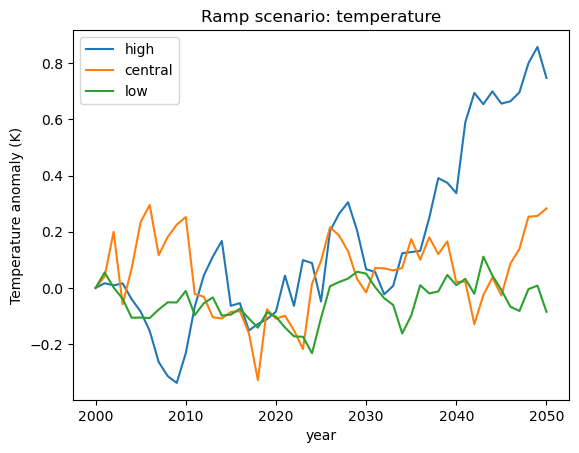

In [128]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ramp', layer=0)], label=f.configs)
pl.title('Ramp scenario: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
pl.legend()

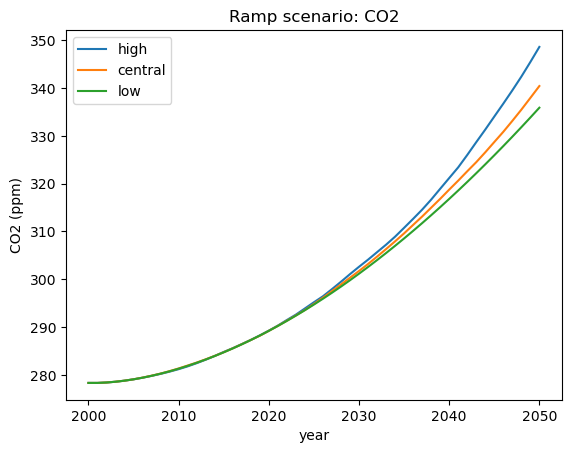

In [129]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ramp', specie='CO2')], label=f.configs)
pl.title('Ramp scenario: CO2')
pl.xlabel('year')
pl.ylabel('CO2 (ppm)')
pl.legend()

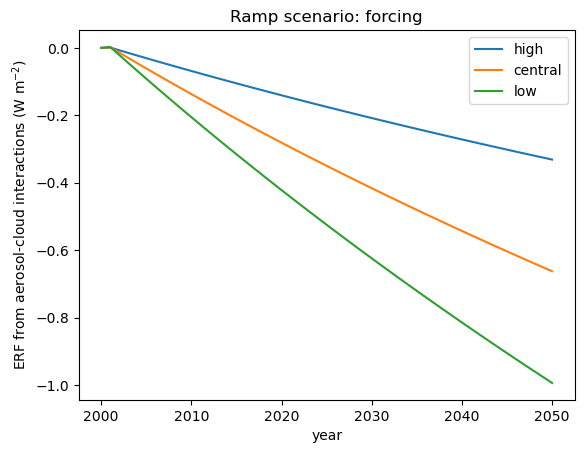

In [130]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ramp', specie='Aerosol-cloud interactions')], label=f.configs)
pl.title('Ramp scenario: forcing')
pl.xlabel('year')
pl.ylabel('ERF from aerosol-cloud interactions (W m$^{-2}$)')
pl.legend()

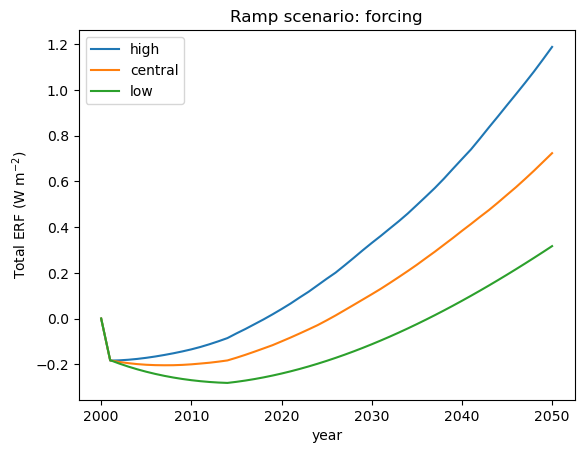

In [131]:
pl.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='ramp')], label=f.configs)
pl.title('Ramp scenario: forcing')
pl.xlabel('year')
pl.ylabel('Total ERF (W m$^{-2}$)')
pl.legend()

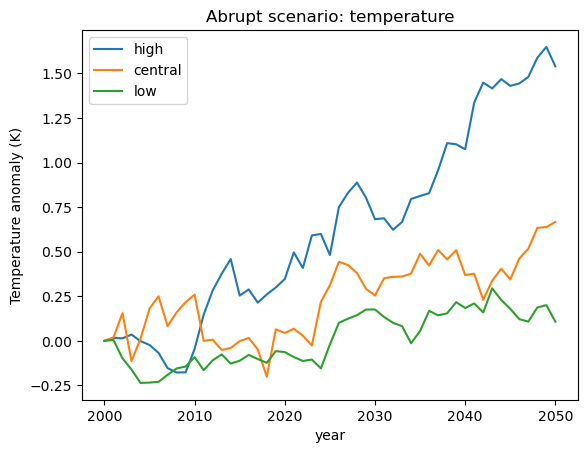

In [132]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='abrupt', layer=0)], label=f.configs)
pl.title('Abrupt scenario: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
pl.legend()

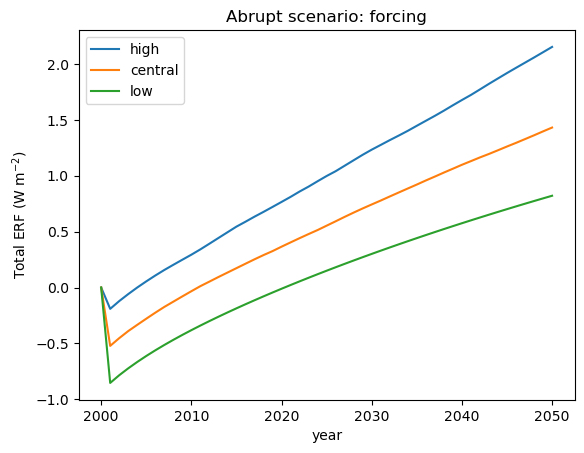

In [133]:
pl.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='abrupt')], label=f.configs)
pl.title('Abrupt scenario: forcing')
pl.xlabel('year')
pl.ylabel('Total ERF (W m$^{-2}$)')
pl.legend()

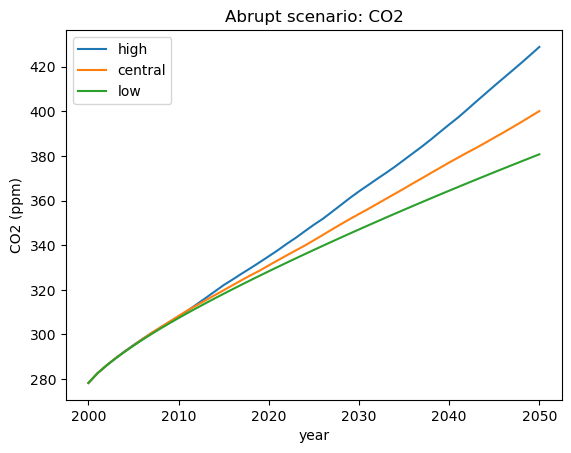

In [134]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='abrupt', specie='CO2')], label=f.configs)
pl.title('Abrupt scenario: CO2')
pl.xlabel('year')
pl.ylabel('CO2 (ppm)')
pl.legend()

In [135]:
f.species_configs['g0'].loc[dict(specie='CO2')]

<xarray.DataArray 'g0' (config: 3)> Size: 24B
array([0.01017829, 0.01017829, 0.01017829])
Coordinates:
  * config   (config) <U7 84B 'high' 'central' 'low'
    specie   <U30 120B 'CO2'

In [136]:
f.forcing[-1, :, 1, :]

<xarray.DataArray (scenario: 2, specie: 9)> Size: 144B
array([[        nan,         nan,  2.03899436,  0.41872696,  0.19278636,
                nan, -0.2       , -0.35728226, -0.66251982],
       [        nan,         nan,  1.13178737,  0.41872696,  0.19278636,
                nan,  0.        , -0.35728226, -0.66251982]])
Coordinates:
    timebounds  float64 8B 2.05e+03
  * scenario    (scenario) <U6 48B 'abrupt' 'ramp'
    config      <U7 28B 'central'
  * specie      (specie) <U30 1kB 'CO2 FFI' ... 'Aerosol-cloud interactions'